# Introduction
<div style="width:100%;height:6px;background-color:Black;"></div>

# .NET Initialization
<div style="width:100%;height:6px;background-color:Black;"></div>

In [1]:
import clr
clr.AddReference(r"..\..\bin\MiniSim.Core")
clr.AddReference(r"..\..\bin\MiniSim.FlowsheetDrawing")

import MiniSim.Core.Expressions as expr
from  MiniSim.Core.Flowsheeting import MaterialStream, Flowsheet,IconTypes
import MiniSim.Core.Numerics as num
from MiniSim.Core.UnitsOfMeasure import Unit, SI, METRIC, PhysicalDimension
from MiniSim.Core.ModelLibrary import Flash, Heater, Mixer, Splitter, EquilibriumStageSection,Source,Sink
import MiniSim.Core.PropertyDatabase as chemsep
from MiniSim.Core.Reporting import Generator, StringBuilderLogger
from MiniSim.Core.Thermodynamics import ThermodynamicSystem
from MiniSim.FlowsheetDrawing import FlowsheetDrawer, DrawingOptions

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx  
from IPython.display import Image as render
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams['grid.color'] = 'k'

# General Objects Instantiation
<div style="width:100%;height:6px;background-color:Black;"></div>

In [4]:
Database = chemsep.ChemSepAdapter()
logger = StringBuilderLogger();
reporter = Generator(logger)

In [5]:
def calc(flowsheet, relax, maxIter):
    presolver=  num.BasicNewtonSolver(logger)
    presolver.MaximumIterations=maxIter
    presolver.BrakeFactor=relax
    presolver.Solve(flowsheet)
    print (logger.Flush())
    
def solve(flowsheet):
    solver= num.DecompositionSolver(logger)
    solver.Solve(flowsheet)
    print (logger.Flush())
    
def convertFlowsheet(flowsheet, options=None):
    drawer= FlowsheetDrawer()
    if(options!=None):
        drawer.Options=options
    return bytes(drawer.DrawAsBase64(flowsheet)) 

def report(item):
    reporter.Report(item)
    print(logger.Flush())
    return

def convertFlowsheet(flowsheet, options=None):
    drawer= FlowsheetDrawer()
    if(options!=None):
        drawer.Options=options
    return bytes(drawer.DrawAsBase64(flowsheet)) 


### Pressure Swing Distillation

Separation of the Methanol and Acetone minimum temperature azeotrope by using the pressure sensitivity of the azeotropic composition of this mixture by operating two columns at different pressures, adapted from [Luyben et al. Ind.Eng.Chem.Res. (2008) 47 pp. 2696-2707.](http://pubs.acs.org/doi/pdf/10.1021/ie701695u).

The number of stages in this flowsheet differs from the specifications used in the ChemSep example.

[Link to the flowsheet drawing](http://www.chemsep.org/downloads/data/Pressure_Swing_MA_iecr47p2696.png)

# Set up Thermodynamics

In [6]:
sys= ThermodynamicSystem("Test2","NRTL", "default")

sys.AddComponent(Database.FindComponent("Acetone"))
sys.AddComponent(Database.FindComponent("Methanol"))
Database.FillBIPs(sys)

kmolh=Unit.Make([SI.kmol],[SI.h])
tonh=Unit.Make([METRIC.ton],[SI.h])

sys.VariableFactory.SetOutputDimension(PhysicalDimension.HeatFlow, SI.MW)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.Pressure, METRIC.bar)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.MassFlow, tonh)

# Create Flowsheet Instance

In [7]:
def createInstance(closeRecycle):
    Feed = MaterialStream("Feed", sys)
    Recycle = MaterialStream("Recycle", sys)


    S01 = MaterialStream("S01", sys)
    S02 = MaterialStream("S02", sys)
    S03 =(MaterialStream("S03", sys)
        #.Init("T", 51, METRIC.C)
        #.Init("P", 1, METRIC.bar)
        #.Init("n[Acetone]",50, kmolh)
        #.Init("n[Methanol]", 50, kmolh)
        #.InitializeFromMolarFlows()
        #.FlashPT()
         )

    S04 = MaterialStream("S04", sys)
    S05 = (MaterialStream("S05", sys)
        #.Init("T", 61, METRIC.C)
        #.Init("P", 1, METRIC.bar)
        #.Init("n[Acetone]",2, kmolh)
        #.Init("n[Methanol]", 100, kmolh)
        #.InitializeFromMolarFlows()
        #.FlashPT()
          )
    Methanol = MaterialStream("Methanol", sys)
    S06 = MaterialStream("S06", sys)
    S07 = MaterialStream("S07", sys)
    S08 = (MaterialStream("S08", sys)
           # .Init("T", 54, METRIC.C)
           # .Init("P", 10, METRIC.bar)
           # .Init("n[Acetone]",50, kmolh)
           # .Init("n[Methanol]", 50, kmolh)
           #.InitializeFromMolarFlows()
           # .FlashPT()
          )
    S09 = MaterialStream("S09", sys)
    S10 = (MaterialStream("S10", sys)
         #   .Init("T", 140, METRIC.C)
         #   .Init("P", 10, METRIC.bar)
         #   .Init("n[Acetone]",100, kmolh)
         #   .Init("n[Methanol]", 2, kmolh)
         #  .InitializeFromMolarFlows()
         #   .FlashPT()
          )
    D1 = MaterialStream("D1", sys)
    Acetone = MaterialStream("Acetone", sys)
    D2 = MaterialStream("D2", sys)


    FeedSource = (Source("FeedSource", sys)
        .Connect("Out", Feed)
        .Specify("T",43, METRIC.C)
        .Specify("P",1, METRIC.bar)
        .Specify("n", 540, kmolh)    
        .Specify("x[Acetone]", 0.5)
        .Specify("x[Methanol]", 0.5))       

  

    C1 = (EquilibriumStageSection("C1",sys,52)
            .Connect("VIn", S05)
            .Connect("LIn", S03)
            .Connect("VOut", S01)
            .Connect("LOut", S04)
            .ConnectFeed(Feed,37)
            .ConnectFeed(Recycle,41)
            .MakeAdiabatic()
            .MakeIsobaric()
            .FixStageEfficiency(1.0)
            )

    REB1 =(Flash("REB1",sys)
            .Connect("In", S04)
            .Connect("Vap", S05)
            .Connect("Liq", Methanol)
            .Specify("P", 1, METRIC.bar)
            .Specify("VF",0.7)
            )

    MethanolSink=Sink("MethanolSink",sys).Connect("In", Methanol)

    COND1 = (Heater("COND1",sys)
            .Connect("In", S01)
            .Connect("Out", S02)
            .Specify("P",1, METRIC.bar)
            .Specify("VF",0)
            )

    RefluxRatio1=2.36
    REFSPL1 = (Splitter("REFSPL1",sys)
            .Connect("In", S02)
            .Connect("Out1", S03)
            .Connect("Out2", D1)
            .Specify("DP",0, METRIC.bar)
            .Specify("K",RefluxRatio1/(1.0+RefluxRatio1))
            )

    AcetoneSink=Sink("AcetoneSink",sys).Connect("In", Acetone)

    C2 = (EquilibriumStageSection("C2",sys,61)
            .Connect("VIn", S10)
            .Connect("LIn", S08)
            .Connect("VOut", S06)
            .Connect("LOut", S09)
            .ConnectFeed(D1,41)
            .MakeAdiabatic()
            .MakeIsobaric()
            .FixStageEfficiency(1.0)
            )

    REB2 = (Flash("REB2",sys)
            .Connect("In", S09)
            .Connect("Vap", S10)
            .Connect("Liq", Acetone)
            .Specify("P",10, METRIC.bar)
            .Specify("VF",0.7)
            )

    COND2 = (Heater("COND2",sys)
            .Connect("In", S06)
            .Connect("Out", S07)
            .Specify("P",10, METRIC.bar)
            .Specify("VF",0)
            )

    RefluxRatio2=3.11
    REFSPL2 = (Splitter("REFSPL2",sys)
            .Connect("In", S07)
            .Connect("Out1", D2)
            .Connect("Out2", S08)
            .Specify("DP",0, METRIC.bar)
            .Specify("K",1-RefluxRatio2/(1.0+RefluxRatio2))
            )

    if(not closeRecycle):
        RecycleSource = (Source("RecycleSource", sys)   
            .Connect("Out", Recycle)
            .Specify("T",54, METRIC.C)
            .Specify("P",10, METRIC.bar)
            .Specify("n", 180, kmolh)   
            .Specify("x[Acetone]",0.1)
            .Specify("x[Methanol]", 0.9)
            )
    else:
        RecycleSource = (Heater("RecycleSource",sys)
            .Connect("In", D2)
            .Connect("Out", Recycle)
            .Specify("DP",9, METRIC.bar)
            .Specify("Q",0, SI.kW)            
            )
        
    FeedSource.SetIcon(IconTypes.Stream, 50,380)
    
    if(not closeRecycle):
        RecycleSource.SetIcon(IconTypes.Stream, 50,240)
    else:
        RecycleSource.SetIcon(IconTypes.Heater, 400,120)
        RecycleSource.RotatePorts(2)
    
    MethanolSink.SetIcon(IconTypes.Stream, 400,700)
    AcetoneSink.SetIcon(IconTypes.Stream, 700,700)
    
    D2.SetIcon(IconTypes.Stream, 760,160)
    
    C1.SetIcon(IconTypes.ColumnSection, 200,300)
    C2.SetIcon(IconTypes.ColumnSection, 500,300)

    COND1.SetIcon(IconTypes.Heater, 300,240)
    REFSPL1.SetIcon(IconTypes.Splitter, 400,240)
    REB1.SetIcon(IconTypes.TwoPhaseFlash, 300,600)
    
    COND2.SetIcon(IconTypes.Heater, 600,240)
    REFSPL2.SetIcon(IconTypes.Splitter, 700,240)
    REB2.SetIcon(IconTypes.TwoPhaseFlash, 600,600)

    flowsheet= (Flowsheet("Flow")
                .AddMaterialStreams(Feed, Recycle, S01,S02,S03,D1,S04,S05,S06,S07,S08,D2,S09,S10,Acetone, Methanol)
                .AddUnits(FeedSource,RecycleSource,C1, REB1, COND1, REFSPL1,C2, REB2, COND2, REFSPL2, AcetoneSink, MethanolSink))
    return flowsheet

# Tearing and calculation sequence

In [8]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

def calculateFractionOfKnownPredecessors(graph, sequence, node):
    all_pre= list(graph.predecessors(node))
    known_pre= intersection(sequence,all_pre)
    return len(known_pre)/len(all_pre)

def generateGraph(flowsheet):
    G=nx.MultiDiGraph()
    #G.add_node(0)
    #G.add_edge(0, 1)
    for u in flowsheet.Units:
        G.add_node(u.Name)
    for s in flowsheet.MaterialStreams:
        #print(f"{s.Name} From: {s.Source} To: {s.Sink}")
        if(s.Source and s.Sink):
            #if(not G.has_edge(s.Sink.Name, s.Source.Name)):
                G.add_edge(s.Source.Name, s.Sink.Name)
    return G

def sequenceFlowsheet(flowsheet):
    G= generateGraph(flowsheet)
    
    sccs=nx.strongly_connected_components(G)
    sccs = list(reversed(list(sccs)))    
    
    seq=[]
    
    for scc in sccs:
        if(len(scc)==1):
            seq.append(list(scc)[0])
        else:
            strongComponent=scc.copy()            
            while(len(strongComponent) !=0):               
                ranking= sorted(strongComponent, 
                                key=lambda n: calculateFractionOfKnownPredecessors(G,seq,n),
                                reverse=True)
                seq.append(ranking[0])
                strongComponent.remove(ranking[0])        
    return G, seq, sccs

    
def initializeFlowsheet(flowsheet,seq,maxIter, solveMode):
    for i in range(maxIter):
        print(f"## iteration {i}")
        errorCounter=0
        for u in seq:        
            try:
                if(not solveMode):
                    flowsheet.GetUnit(u).Initialize()
                else:
                    flowsheet.GetUnit(u).Solve()
                print(f"Unit {u} initialized")
            except: 
                print(f"** Unit {u} not initialized")
                errorCounter+=1
    return
        
def drawGraph(G):
    nx.draw(G, with_labels=True, node_color='LightGrey')

# Test with Open Recycle between distillation units

In [9]:
flowsheet=createInstance(False)

G, seq,scc= sequenceFlowsheet(flowsheet)

for sc in list(scc):
    print(sc) 
        
for u in list(seq):
    print(u)
        

{'RecycleSource'}
{'FeedSource'}
{'REB1', 'REFSPL1', 'COND1', 'C1'}
{'MethanolSink'}
{'C2', 'COND2', 'REB2', 'REFSPL2'}
{'AcetoneSink'}
RecycleSource
FeedSource
C1
REB1
COND1
REFSPL1
MethanolSink
C2
COND2
REB2
REFSPL2
AcetoneSink


In [10]:
cyc= nx.algorithms.cycles.simple_cycles(G)
for c in cyc:    
    print(c)

['REB1', 'C1']
['REFSPL1', 'C1', 'COND1']
['C2', 'REB2']
['C2', 'COND2', 'REFSPL2']


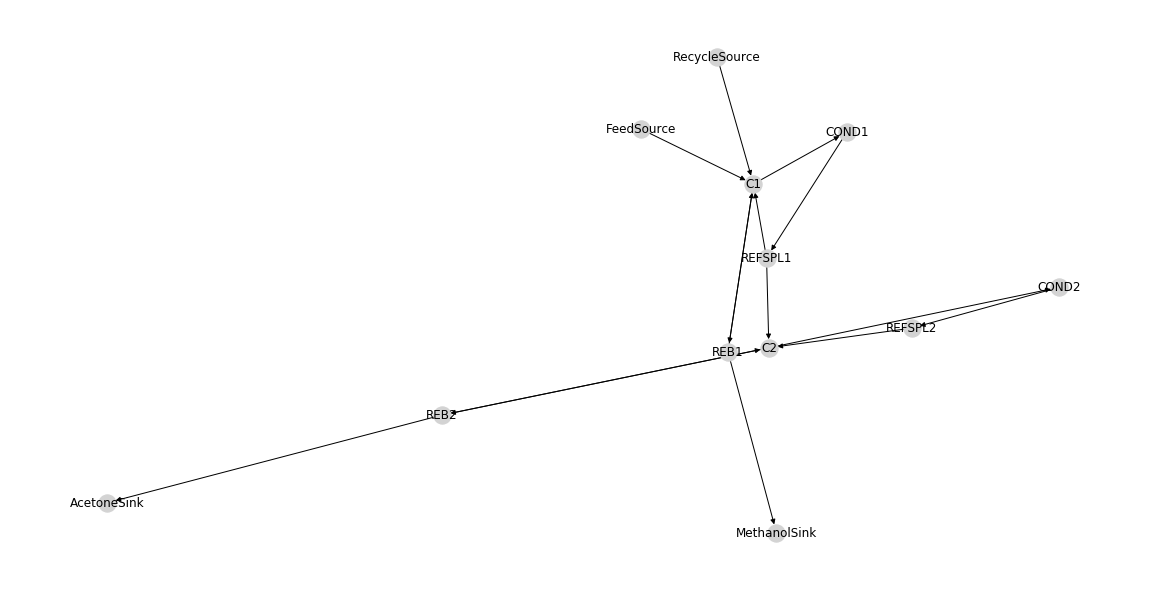

In [11]:
drawGraph(G)

In [12]:
initializeFlowsheet(flowsheet, seq, 4,False)

print(f"## Solve step")
initializeFlowsheet(flowsheet, seq,1, True)    

## iteration 0
Unit RecycleSource initialized
Unit FeedSource initialized
** Unit C1 not initialized
Unit REB1 initialized
** Unit COND1 not initialized
** Unit REFSPL1 not initialized
Unit MethanolSink initialized
** Unit C2 not initialized
** Unit COND2 not initialized
** Unit REB2 not initialized
** Unit REFSPL2 not initialized
Unit AcetoneSink initialized
## iteration 1
Unit RecycleSource initialized
Unit FeedSource initialized
Unit C1 initialized
Unit REB1 initialized
Unit COND1 initialized
Unit REFSPL1 initialized
Unit MethanolSink initialized
** Unit C2 not initialized
** Unit COND2 not initialized
Unit REB2 initialized
** Unit REFSPL2 not initialized
Unit AcetoneSink initialized
## iteration 2
Unit RecycleSource initialized
Unit FeedSource initialized
Unit C1 initialized
Unit REB1 initialized
Unit COND1 initialized
Unit REFSPL1 initialized
Unit MethanolSink initialized
Unit C2 initialized
Unit COND2 initialized
Unit REB2 initialized
Unit REFSPL2 initialized
Unit AcetoneSink ini

In [13]:
solve(flowsheet)

Decomposition Result: V=1793, E=1793, Blocks=487, Singletons=471
Block Statistics:
   # Var # Blocks % Blocks
       1      471  96,71 %
       5        8   1,64 %
       6        6   1,23 %
     578        1   0,21 %
     668        1   0,21 %
Problem Flow was successfully solved (0,415 seconds)



In [14]:
colors=["Red", "Green", "Blue", "LightBlue","Violet", "Purple", "YellowGreen"]

for i, sc in enumerate(list(scc)):
    for n in list(sc):
        flowsheet.GetUnit(n).SetColors(colors[i],colors[i])        
    

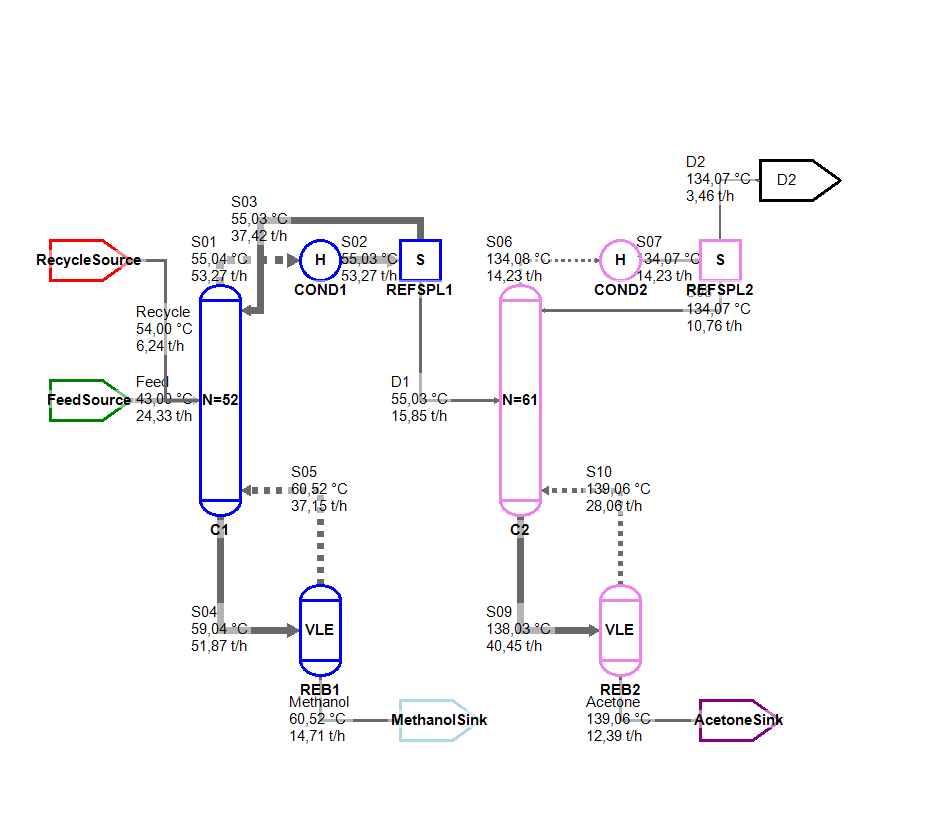

In [15]:
options=DrawingOptions()
options.ShowStreamWidth=True
options.ShowPressure=False
options.ShowTemperature=True
options.ShowStreamColors=False
options.ColorMap["Acetone"]="Blue"
options.ColorMap["Methanol"]="Purple"
render(convertFlowsheet(flowsheet,options))

# Test with closed recycle between distillation units

In [16]:
flowsheet2=createInstance(True)
G, seq,scc= sequenceFlowsheet(flowsheet2)
print(f"## Init step")
initializeFlowsheet(flowsheet2, seq, 3,False)
print(f"## Solve step")
initializeFlowsheet(flowsheet2, seq,1, True) 
solve(flowsheet2)

## Init step
## iteration 0
Unit FeedSource initialized
** Unit C1 not initialized
Unit REB1 initialized
** Unit COND1 not initialized
** Unit REFSPL1 not initialized
** Unit C2 not initialized
** Unit REB2 not initialized
** Unit COND2 not initialized
** Unit REFSPL2 not initialized
Unit RecycleSource initialized
Unit MethanolSink initialized
Unit AcetoneSink initialized
## iteration 1
Unit FeedSource initialized
Unit C1 initialized
Unit REB1 initialized
Unit COND1 initialized
Unit REFSPL1 initialized
** Unit C2 not initialized
Unit REB2 initialized
** Unit COND2 not initialized
** Unit REFSPL2 not initialized
Unit RecycleSource initialized
Unit MethanolSink initialized
Unit AcetoneSink initialized
## iteration 2
Unit FeedSource initialized
Unit C1 initialized
Unit REB1 initialized
Unit COND1 initialized
Unit REFSPL1 initialized
Unit C2 initialized
Unit REB2 initialized
Unit COND2 initialized
Unit REFSPL2 initialized
Unit RecycleSource initialized
Unit MethanolSink initialized
Unit Ac

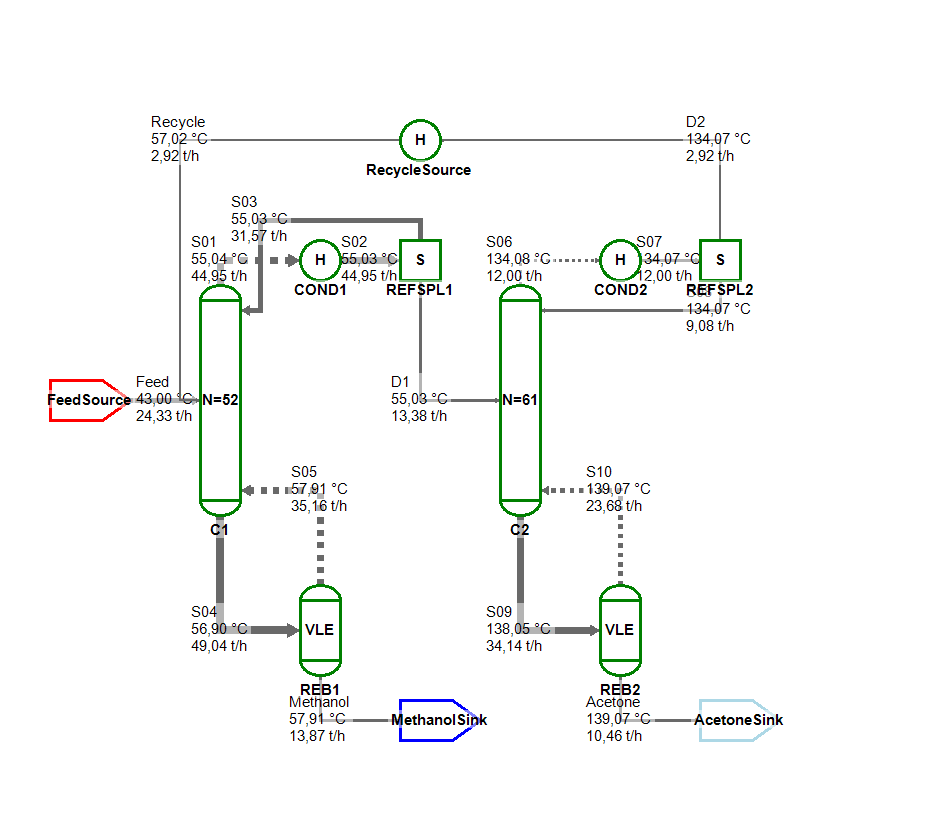

In [17]:
for i, sc in enumerate(list(scc)):
    for n in list(sc):
        flowsheet2.GetUnit(n).SetColors(colors[i],colors[i])       
render(convertFlowsheet(flowsheet2,options))        

In [18]:
reporter.Report(flowsheet, 4, False)
print(logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle          S01          S02

Temperature               °C              43.0000      54.0000      55.0439      55.0343
Pressure                  bar              1.0000      10.0000       1.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.0000       1.0000       0.0000
Specific Enthalpy         kJ/kmol     -32510.3979  -34077.0358    2086.1392  -29147.0098
Phase                                      Liquid       Liquid        Vapor  BubblePoint
Density                   kmol/cum        17.0475      21.9261       0.0366      14.5402
Mass Density              kg/cum         768.1702     759.6414       1.8980     753.0416
Volume Flow               cum/h           31.6761       8.2094   28066.8591      70.7392
Molar Weight              kg/kmol         45.0605      34.6456      51.7905      51.7905

Total Molar Flow       